In [127]:
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize 
nltk.download('punkt')

import gensim
from gensim.models import Word2Vec

import warnings 
warnings.filterwarnings(action = 'ignore')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import operator

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/barrettpoth/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
products = pd.read_csv('final_data/products.csv')
reviews = pd.read_csv('final_data/reviews.csv')

In [4]:
reviews = pd.read_csv("reviews.csv")
reviews = reviews.drop(columns=["Unnamed: 0"])

In [8]:
# data is a list of sentences, and sentences are lists of words
data = []
for index, row in reviews.iterrows():
    r = row['Review']
    for i in sent_tokenize(r):
        sentence = []
        for j in word_tokenize(i):
            sentence.append(j.lower())
        data.append(sentence)

In [9]:
# create skip gram word embedding model from our review data
sg_model = gensim.models.Word2Vec(data, min_count = 1, size = 100, 
                                             window = 5, sg = 1)

In [10]:
# freatures are the features that the customers we are recommending to care about 
features = ['powder']

# calculate similarities for each review and the list of features
similarities = []
for index, row in reviews.iterrows():
    r = row['Review']
    r_sents = sent_tokenize(r)
    r_sent_words = [word_tokenize(s) for s in r_sents]
    r_words = []
    for s in r_sent_words:
        for w in s:
            r_words.append(w)
    r_words = [w.lower() for w in r_words]
    try:
        similarities.append(sg_model.n_similarity(features, r_words))
    except:
        similarities.append(0)

In [12]:
reviews['similarities'] = similarities

In [14]:
# get sentiment score for each review
analyser = SentimentIntensityAnalyzer()
review_sentiments = []
for r in reviews.itertuples():
    snt = analyser.polarity_scores(r.Review)
    review_sentiments.append(snt)
review_sentiments = [r['compound'] for r in review_sentiments]

In [15]:
reviews['sentiments'] = review_sentiments

In [16]:
# start getting avg sentiment and cosine similarity for each product
# create dictionaries: key is product name, value is list of sentiments and cos similarities for that product
makeup_cs_dict = {}
makeup_sent_dict = {}
for r in reviews.itertuples():
    
    if r.Product in makeup_sent_dict:
        makeup_sent_dict[r.Product].append(r.sentiments)
    else:
        makeup_sent_dict[r.Product] = [r.sentiments]
        
    if r.Product in makeup_cs_dict:
        makeup_cs_dict[r.Product].append(r.similarities)
    else:
        makeup_cs_dict[r.Product] = [r.similarities]        

In [17]:
# return average of list
def avg(lst): 
    return sum(lst) / len(lst) 

In [18]:
# create dictionaries: key is product name, value is avg sentiment and cos similarities for that rest
makeup_cs_avg_dict = {}
makeup_sent_avg_dict = {}
for r in makeup_cs_dict:
    makeup_cs_avg_dict[r] = avg(makeup_cs_dict[r])
    makeup_sent_avg_dict[r] = avg(makeup_sent_dict[r])

In [19]:
# get sorted lists of makeup_cs_avg_dict and makeup_sent_avg_dict
makeup_cs_avg = sorted(makeup_cs_avg_dict.items(), key=operator.itemgetter(1))
makeup_cs_avg.reverse()

makeup_sent_avg = sorted(makeup_sent_avg_dict.items(), key=operator.itemgetter(1))
makeup_sent_avg.reverse()

In [20]:
# create dictionary: key is product name, value is sentiment score * cosine similarity for that product
makeup_cs_sent_dict = {}
for m in makeup_cs_dict:
    cs = makeup_cs_avg_dict[m]
    sent = makeup_sent_avg_dict[m]
    makeup_cs_sent_dict[m] = cs * sent

In [21]:
# get sorted list of makeup_cs_send_dict
makeup_cs_sent = sorted(makeup_cs_sent_dict.items(), key=operator.itemgetter(1))
makeup_cs_sent.reverse()

#### Recommendations

In [97]:
# get top n recommendations based on sentiment score and cosine similarity multiple
recommendations = [m[0] for m in makeup_cs_sent[:5]]
for i in range (len(recommendations)):
    output = str(i+1) + '.  Name: ' + recommendations[i]
    output += '\n            Cos: ' + str(makeup_cs_avg_dict[recommendations[i]])
    output += '\n           Sent: ' + str(makeup_sent_avg_dict[recommendations[i]])
    r_row = products.loc[products['Product'] == bucket_recommendations[i]]
    percentage = r_row['Percentage Would Buy Again'].head(1)
    output += '\n Perc buy again: ' + str(float(percentage))
    print (output, end='\n\n')

1.  Name: Multistick
            Cos: 0.6695983066008642
           Sent: 0.9234384615384615
 Perc buy again: 0.63

2.  Name: Chubby in the Nude Foundation Stick
            Cos: 0.6773602962493896
           Sent: 0.9122090909090907
 Perc buy again: 0.64

3.  Name: Cream Foundation
            Cos: 0.6752373996902915
           Sent: 0.9082117647058825
 Perc buy again: 0.65

4.  Name: Super BB All-in-1 Beauty Balm Stick
            Cos: 0.6775784322193691
           Sent: 0.8806500000000002
 Perc buy again: 0.71

5.  Name: W3LL People Narcissist 
            Cos: 0.680633932352066
           Sent: 0.8528642857142857
 Perc buy again: 0.78



In [81]:
# get top n recommendations based on sentiment score buckets and cosine similarity.
bucket_recommendations = []
for i in range (len(makeup_cs_avg)):
    product = makeup_cs_avg[i][0]
    if makeup_sent_avg_dict[product] >= .9:
        bucket_recommendations.append(product)
for i in range (len(makeup_cs_avg)):
    product = makeup_cs_avg[i][0]
    if makeup_sent_avg_dict[product] >= .8 and makeup_sent_avg_dict[product] < .9:
        bucket_recommendations.append(product)
for i in range (len(makeup_cs_avg)):
    product = makeup_cs_avg[i][0]
    if makeup_sent_avg_dict[product] >= .7 and makeup_sent_avg_dict[product] >= .8:
        bucket_recommendations.append(product)

In [98]:
# get top n recommendations based on sentiment score and cosine similarity multiple
for i in range (len(bucket_recommendations[:5])):
    output = str(i+1) + '.  Name: ' + bucket_recommendations[i]
    output += '\n            Cos: ' + str(makeup_cs_avg_dict[bucket_recommendations[i]])
    output += '\n           Sent: ' + str(makeup_sent_avg_dict[bucket_recommendations[i]])
    
    r_row = products.loc[products['Product'] == bucket_recommendations[i]]
    percentage = r_row['Percentage Would Buy Again'].head(1)
    output += '\n Perc buy again: ' + str(float(percentage))
    print (output, end='\n\n')

1.  Name: Chubby in the Nude Foundation Stick
            Cos: 0.6773602962493896
           Sent: 0.9122090909090907
 Perc buy again: 0.63

2.  Name: Cream Foundation
            Cos: 0.6752373996902915
           Sent: 0.9082117647058825
 Perc buy again: 0.64

3.  Name: Multistick
            Cos: 0.6695983066008642
           Sent: 0.9234384615384615
 Perc buy again: 0.65

4.  Name: W3LL People Narcissist 
            Cos: 0.680633932352066
           Sent: 0.8528642857142857
 Perc buy again: 0.71

5.  Name: Nobara cream cover stick
            Cos: 0.6802253362379576
           Sent: 0.8413105263157895
 Perc buy again: 0.78



In [122]:
# start plotting sentiments vs percentage would by again
# create a dictionary, key is product name, value is (sentiment, pba)
sent_vs_pba_dict = {}
for p in makeup_sent_avg_asc:
    r_row = products.loc[products['Product'] == p[0]]
    percentage = r_row['Percentage Would Buy Again'].head(1)
    sent_vs_pba_dict[p[0]] = (p[1], float(percentage))

In [126]:
pba = []
sent = []
for k in sent_vs_pba_dict:
    pba.append(sent_vs_pba_dict[k][0])
    sent.append(sent_vs_pba_dict[k][1])

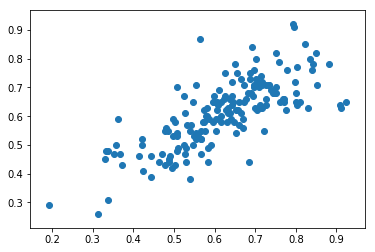

In [128]:
plt.scatter(pba, sent)